In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [2]:
def wrangle(csv_file):

    #read file
    df = pd.read_csv(csv_file)
    
    #leaky columns
    cols_to_drop = []

    #recast target
    df['Transported'] = df['Transported'].astype(int)

    #identify multicollinearity

    
    #high cardinality features   
    cols_to_drop.extend(['PassengerId', 'Name', 'Cabin'])
    
    

    #drop columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df

In [3]:
#read csv and check first rows
df = wrangle('train.csv')
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [4]:
#get information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 747.2+ KB


In [5]:
cat = df.select_dtypes('object').columns

print(df[cat].nunique())
print("*****************")

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
dtype: int64
*****************


In [6]:
df['Transported'].astype(int).head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

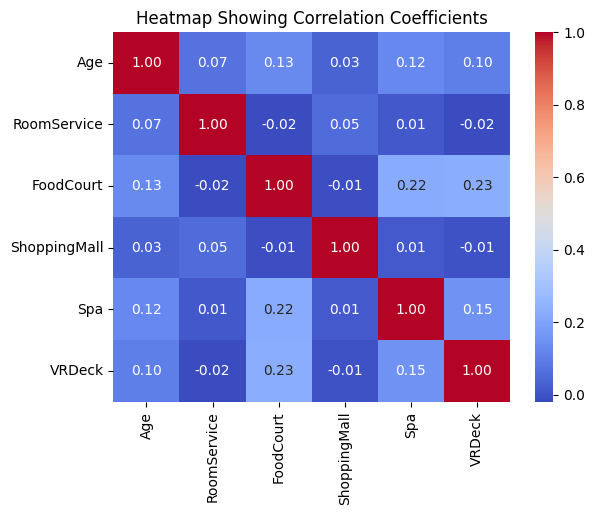

In [7]:
#get correlation of numerical features
num_corr = df.select_dtypes('float').corr()
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Showing Correlation Coefficients');


In [8]:
#describe
num_feat = df.select_dtypes('float').describe()
num_feat

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


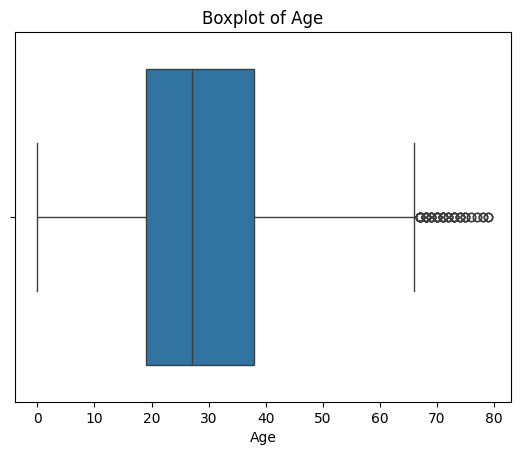

888888888888888


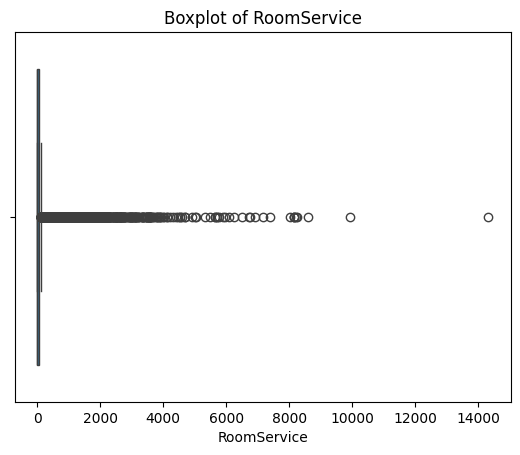

888888888888888


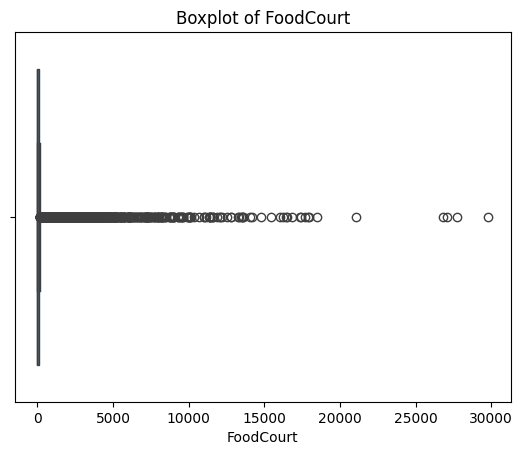

888888888888888


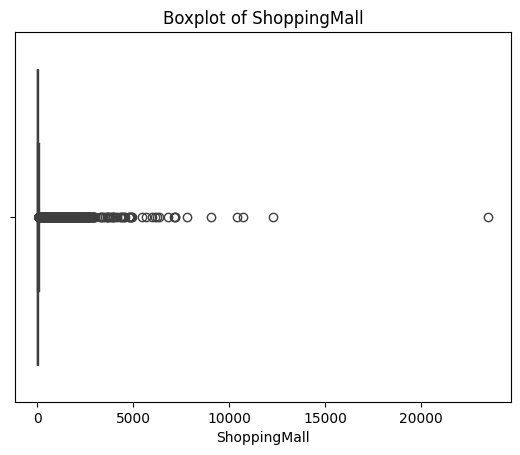

888888888888888


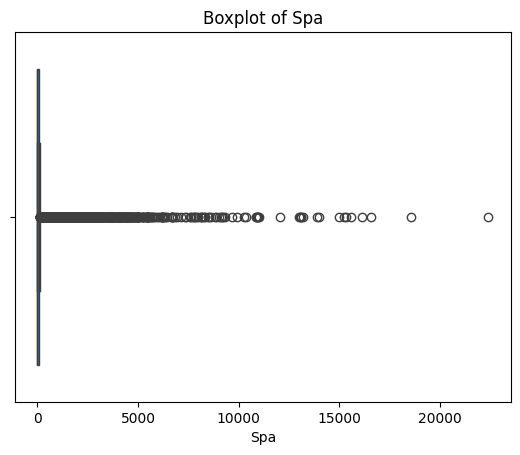

888888888888888


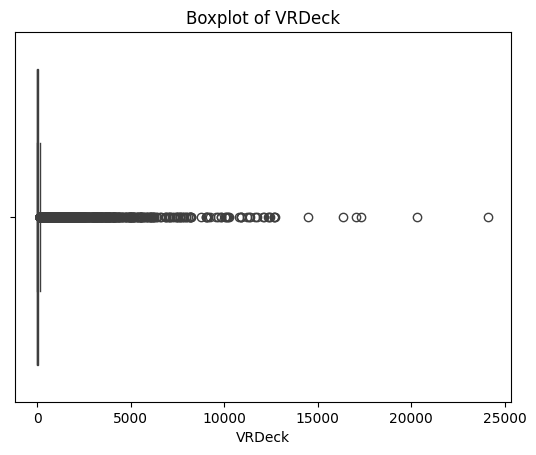

888888888888888


In [9]:
#plot boxplots
for col in num_feat.columns:
    col_plot = df[col]
    sns.boxplot(col_plot, orient='h')
    plt.title(f'Boxplot of {col}')
    plt.show()
    print('888888888888888')

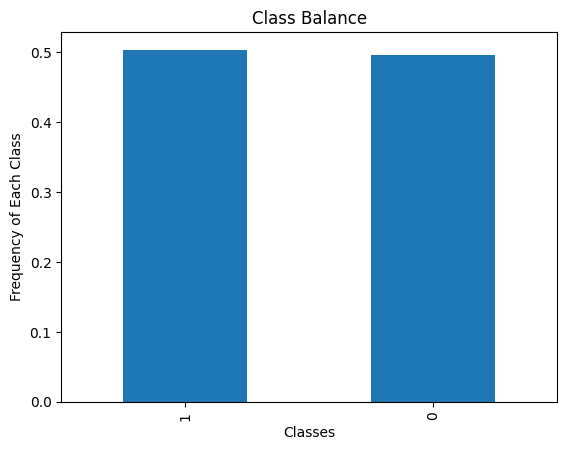

In [10]:
#check class balance
df['Transported'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Frequency of Each Class')
plt.title('Class Balance');

In [11]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [12]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [13]:
print(df.columns)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')


In [14]:
#get features and target
target = 'Transported'
X = df.drop(columns=target)
y = df[target]
print('DF Shape', df.shape)
print('X shape',X.shape)
print('Y', y.shape)

DF Shape (8693, 11)
X shape (8693, 10)
Y (8693,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


X_train (6954, 10)
X_test (1739, 10)
y_train (6954,)
y_test (1739,)


In [16]:
cat_feat = X.select_dtypes('float').columns
num_feat = X.select_dtypes('float').columns


In [17]:
baseline_score = y.value_counts(normalize=True).max()
print('Baseline accuracy', baseline_score)


Baseline accuracy 0.5036236051995858


In [18]:
#preprocessing
preprocessor =  ColumnTransformer([
    ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat_feat),
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num_feat)
])


In [19]:
#make pipeline
model_log = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

#fit model
model_log.fit(X_train, y_train)

#train model
y_pred_train = model_log.predict(X_train)

#train accuracy
acc_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy:', round(acc_train, 2))

#predict on test set
y_pred_test = model_log.predict(X_test)

#test accuracy
acc_test = accuracy_score(y_test, y_pred_test)
print('Test Accuracy:', round(acc_test, 2))

#cross validation
cv_scores = cross_val_score(model_log, X, y, cv=5, scoring='accuracy')
print('Average cross validation score:', round(cv_scores.mean(), 2))

Train Accuracy: 0.85
Test Accuracy: 0.78
Average cross validation score: 0.78


In [20]:
#make pipeline for decision tree
model_tr = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=42)
)

#fit model
model_tr.fit(X_train, y_train)

#train model
y_pred_train = model_tr.predict(X_train)

#train accuracy
acc_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy:', round(acc_train, 2))

#predict on test set
y_pred_test = model_tr.predict(X_test)

#test accuracy
acc_test = accuracy_score(y_test, y_pred_test)
print('Test Accuracy:', round(acc_test, 2))

#cross validation
cv_scores = cross_val_score(model_tr, X, y, cv=5, scoring='accuracy')
print('Average cross validation score:', round(cv_scores.mean(), 2))

Train Accuracy: 0.92
Test Accuracy: 0.75
Average cross validation score: 0.75


In [21]:
#tree depth
depth = model_tr.named_steps['decisiontreeclassifier'].get_depth()
depth

100

In [32]:

#store acc scores
training_accuracy = []
test_accuracy = []

#tune model
params = range(1, 101, 2)
for d in params:
    model_tr = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth= d, random_state=42)
    )

    #fit model
    model_tr.fit(X_train, y_train)

    #train model
    y_pred_train = model_tr.predict(X_train)

    #train accuracy
    acc_train = accuracy_score(y_train, y_pred_train)

    #append training score
    training_accuracy.append(acc_train)

    #predict on test set
    y_pred_test = model_tr.predict(X_test)

    #test accuracy
    acc_test = accuracy_score(y_test, y_pred_test)

    #append test scores
    test_accuracy.append(acc_test)


In [33]:
print('Training accuracy scores:', training_accuracy[:3])
print('Test accuracy scores:', test_accuracy[:3])

Training accuracy scores: [0.6670980730514812, 0.7765314926660914, 0.7935001438021283]
Test accuracy scores: [0.6653248993674525, 0.7648073605520413, 0.7659574468085106]


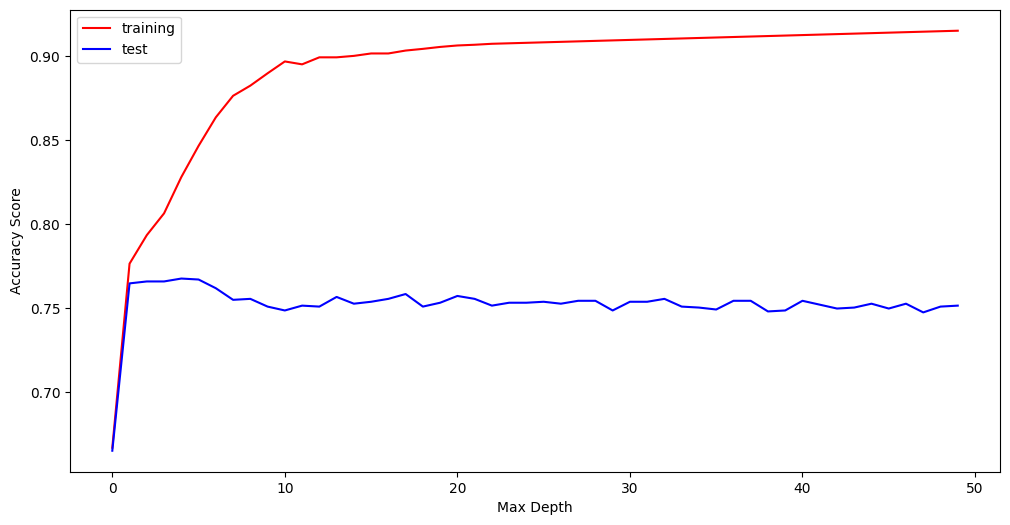

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(training_accuracy, color='red', label='training')
ax.plot(test_accuracy, color='blue', label='test')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy Score')
ax.legend()
plt.show();